# Results of MD simulations of collision cascades in hcp Zr at 600 K.
---

Bartosz Barzdajn and Christpher P. Race

---

This document describes a database containing pre- and post-processing
scripts, input files and results from molecular dynamics (MD)
simulations of collision cascades in LAMMPS [1]. The material studied
was hcp Zr at the temperature of 600 K. In addition, this document
illustrates methods for accessing and analysing the data using the
Python programming language and its well-established libraries. The
focus will be on the estimation of the most relevant quantities in the
context of radiation damage.

# Description of the database

To access the data using the methods provided in this document, extract
the `pka_004.tar.xz` archive into `pka_004`. Many GNU/Linux
distributions, as well as MacOS, already include utilities capable of
handling `xz` archives. On Windows, one can utilize free and open-source
tools like `7z` or `PeaZip`.

The results of each simulation consist of:

1.  The initial state, which contains the coordinates of the equilibrium
    atomic positions, and the final state of the system. These results
    include information about all atoms in the computational cell.
2.  Evolution of global (intensive) properties such as temperature,
    pressure, average inter-atomic potential energy, etc.
3.  Occupancy of equilibrium sites as a function of simulation time, as
    well as the positions of nodes containing vacancies and
    self-interstitial atoms.
4.  Likewise, the "actual" positions of the self-interstitial atoms
    during the simulations are provided.

The key characteristics of the database are as follows:

1.  Range of kinetic energies of primary knock-on atoms (PKAs): 0-40
    keV. This range corresponds approximately to the lower half of the
    PWR [2] neutron PKA spectrum.
2.  Temperature approximately 600 K.
3.  Uniform importance sampling of PKA momenta, with directions selected
    by solving the Thomson problem. This also implies that none of the
    directions were favored.
4.  Uniform sampling of the PKA energy.
5.  There are 256 simulations, each with computational cells consisting
    of 2097152 atoms. The running time varied; however, the target was
    approximately 40 ps.

# Database structure

The database consists of plain text files organized in a hierarchy of
folders. All units in the database are provided in the LAMMPS "metal"
system.

## Files necessary to reproduce the results

The root of the database, where `pka_004.tar.xz` was extracted, contains
the following files:

``` example
in.go           zr_2097152         Zr_1.eam.fs
in.pka          temp_grid_13.init  Zr_2.eam.fs 
run.mkjobs                         Zr_3.eam.fs 
ws_analisys.py                     restart.hcp.equilibrium
                                   Zr.eam.fs
```

The files `in.go` and `in.pka` are LAMMPS input files. The first was
responsible for optimising the geometry, the second for running the
cascade simulation. The next file in the column – `run.mkjobs` is a BASH
script that creates "jobs", *i.e* folders of the pattern `pka_???`[3],
in which the respective simulations were carried out. The folder also
contains copies of modified files such as the potential or the
particular LAMMPS input file. This brings us to another role of this
script, *i.e.* is to assign appropriate momentum to the PKA. The file
contains a list of velocities selected so the kinetic energy is sampled
uniformly across all 256 simulations and an `awk` command that modifies
the `in.pka`. The last file in this column is `ws_analisys.py`, which
contains code to identify vacancies and self-interstitials.

The files `in.go` and `in.pka` are LAMMPS input files. The former is
responsible for optimizing the geometry, while the latter is used for
running the cascade simulation. The subsequent file in the column,
`run.mkjobs`, is a BASH script that generates "jobs", i.e., folders of
the pattern `pka_???`[4], wherein the respective simulations are
conducted. Additionally, the folder includes duplicates of modified
files such as the potential or the specific LAMMPS input file. This
leads us to another role of this script, i.e., assigning appropriate
momentum to the PKA. The file contains a list of velocities selected to
ensure that kinetic energy is uniformly sampled across all 256
simulations and an `awk` command that modifies the `in.pka`. The final
file in this column is `ws_analysis.py`, which contains code designed to
identify vacancies and self-interstitials.

The remaining files can be described briefly. The `zr_2097152` contains
the starting atomic configuration while `temp_grid_13.init` defines the
TTM initial state. Finally, the `*.fs` files are the potential files and
the `restart.hcp.equilibrium` is a restart file from the geometry
optimisation stage.

The results of the simulations can be found in `pka_???` directories,
that are also inside the root directory. Each contains the following
files:

``` example
in.pka  log.lammps  out.pka  restart.pka  temp_grid_13.init
temp_grid_13.out  ws_analisys.py  Zr_1.eam.fs  Zr_2.eam.fs  Zr_3.eam.fs
```

Here, `in.pka` is the file with the given PKA energy or velocity,
`log.lammps` and `out.pka` are standard output of a LAMMPS "run" and the
restart is, as before, a file used to restart the simulation if it was
terminated abnormally. The last file to consider is the
`temp_grid_13.out` which contains the final temperature grid from the
TTM model.

## Results of simulations

The main results are stored in the `data` and `dumps` subfolders of the
`pka_???` parent simulation directories. We will start with the first,
which contains data on the evolution of cascades.

The simulation parameters are located in `data.pka`, which is a `csv`
file with the following fields organised in columns: `step` – step
number, `dt` – value of the self-adjusting time step, `time` –
simulation time, `ETOT` – total energy of the system, `TN` – nominal
temperature, `T` – temperature, `P` – pressure, `v/at` – volume per
atom, `pe_avg` – average potential energy, `pe_std` – associated
standard deviation, `pe_min` minimum potential energy, `pe_max` maximum
potential energy, `ke_avg` – average kinetic energy, `ke_std` –
associated standard deviation, `ke_min` – minimum kinetic energy,
`ke_max` – maximum kinetic energy. The statistics are calculated on the
per-atom basis.

The first category of files that contains positions of defects are those
of the pattern `int_xyz.*`[5]. These files represent the positions of
atom classified as self-interstitial atoms (sia), i.e. those associated
with equilibrium atomic sites that turned out to have more than one
occupancy according to the Wigner-Seitz analysis. Next, the files
`int_pos.*` and `vac_pos.*` contain coordinates of sites containing sia
and vacancies (vac). The last category – `nodes_occupancy.*.npz`,
consists of binary NumPy files containing 3 matrices. The first
represents the total number of atoms, the second contains indices of
atomic sites (coordinates stored in `./pka_???/dumps/dump.en_0`
described later) with point defects and the third contains occupancy
numbers.

In all files the integer part of the file name corresponds to the LAMMPS
step number. The simulation time can be calculated by interpolating the
time and step in `data.pka`. How to do this will be demonstrated later.

Files discussed above were generated using the `ws_analisys.py` program.

Results containing information about all atomic positions are stored in
the `dumps` subdirectory. Here we find LAMMPS dump files, the purpose of
which is indicated by the suffix. As these files are very large, only
the initial (`dump.en_0`) and the final state (`dump.en_1`) have been
saved. The exception is `dump.c`, which is a snapshot of the most recent
state. File `dump.en_min_0` is the state of `dump.en_0` after energy
minimisation with fixed cell geometry and represents the coordinates of
the equilibrium lattice sites. This file, together with
`nodes_occupancy.*.npz`, recreates the positions of all defects.

The final note is that the atomic id's are consistent across all files
so that we can identify displaced atoms. This will be demonstrated later
in this document.

# List of examples and their purpose

1.  Section <span class="spurious-link"
    target="Simulation hyper-parameters">*Simulation
    hyper-parameters*</span> (Simulation hyper-parameters)  
    Generate a list of folders containing cascade simulations and parse
    input files to obtain the kinetic energy of the PKAs.
2.  Section <span class="spurious-link"
    target="Global simulation and physical parameters">*Global
    simulation and physical parameters*</span> (Global simulation and
    physical parameters)  
    Parse `data.pka` to obtain information about the time evolution of
    various parameters such as temperature, pressure, average kinetic
    energy, etc..
3.  Section <span class="spurious-link"
    target="Number of cascades">*Number of cascades*</span> (Number of
    cascades)  
    Parse the `nodes_occupancy.*.npz` files to access information about
    node occupancy and count the number of point defects.
4.  Section <span class="spurious-link"
    target="Evolution of the size of collision cascades">*Evolution of
    the size of collision cascades*</span> (Evolution of the size of
    collision cascades)  
    Demonstrate how to obtain coordinates of defects and their evolution
    in time.
5.  Section <span class="spurious-link"
    target="Damage vs. displacement">*Damage vs. displacement*</span>
    (Damage vs. displacement)  
    Accessing information about positions of all atoms, identifying
    displaced atoms and actual point defects (combining `dump.en_1` and
    `nodes_occupancy.*.npz`).

# Modules and related settings

Set Matplotlib backend in Jupyter notebooks.

In [1]:
%config InlineBackend.figure_format = 'svg'

Load all necessary modules right from the start.

In [2]:
import os
import re
import warnings
from dataclasses import dataclass, field
from glob import glob
from itertools import count, starmap

import atomman as am
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import scienceplots
import seaborn as sns
from scipy.interpolate import interp1d
from sklearn.decomposition import PCA



Temporary fix for the issue #3462 in the Seaborn library
(<https://github.com/mwaskom/seaborn/issues/3462>).

In [3]:
warnings.filterwarnings("ignore", "is_categorical_dtype")
warnings.filterwarnings("ignore", "use_inf_as_na")

Set-up styling of Matplotlib figures..

In [4]:
plt.style.use(["default", "science", "retro"])
plt.rc("figure", figsize=[4, 3])

# Utilities

The definition of the context manager for handling the creation of
figures and saving them in different formats.

In [5]:
class PlotAndSave():

    def __init__(self, file_name, n, m, scale_w=1.0, scale_h=1.0, sharex="none", sharey="none", directory="./assets"):
        self.file_name = file_name
        self.sw, self.sh = scale_w, scale_h
        self.n, self.m = n, m
        self.directory = directory
        self.sharex = sharex
        self.sharey = sharey

    def __enter__(self):

        self.fig, self.axs = plt.subplots(self.n, self.m, sharex=self.sharex, sharey=self.sharey)
        pw, ph = self.fig.get_size_inches()
        self.fig.set_size_inches(self.sw * min(2, self.m) * pw, self.sh * self.n * ph)

        return self.fig, self.axs

    def __exit__(self, exc_type, exc_value, exc_traceback):

        if not os.path.isdir(self.directory):
            print("Creating: ", self.directory)
        else:
            pass # print(directory, "folder already exists.")

        for ext in ("pdf", "svg", "png"):
            # kwargs = {"backend": "cairo"} if ext == "pnd" else {}
            self.fig.savefig(f"{self.directory}/{self.file_name}.{ext}", bbox_inches="tight", transparent=True, dpi=300) # , **kwargs)

        plt.show()        # Call this method in Jupyter notebooks to display images inline.
        plt.close("all")


# Simulation hyper-parameters

Here, we define data-class to store simulation parameters, including
path to results for given PKA energy.

In [6]:
@dataclass
class SimHP:
    """Class containing global simulation hyper-parameters."""

    root    : str         = "/run/media/zockoshi/EXT4/sim_04" # r"./sim_04"
    sim_dir : list[str]   = field(default_factory=list)
    pka_v   : list[float] = field(default_factory=list)
    pka_en  : list[float] = field(default_factory=list)

    def get_sim_dir(self) -> list:
        self.sim_dir = sorted(glob(f"{self.root}/pka_*"))

    def get_pka_prop(self) -> list:
        for d in self.sim_dir:
            with open(f"{d}/in.pka", "r") as f:
                c = f.read()

            v = list(map(float, re.findall("velocity PKA set .*\n", c, re.MULTILINE)[0].split(" ")[-3:]))
            self.pka_v.append(v)

            v = np.array(v)
            v_si = v * 10**(-10) / 10**(-12)                   # A / ps to m / s.
            e_kin_si = 1.51481 * 10**(-25) * v_si @ v_si / 2   
            e_kin = e_kin_si * 6.242e+18 / 1000                # Convert to keV.
            self.pka_en.append(e_kin)



hyper_prm = SimHP() 
hyper_prm.get_sim_dir()
hyper_prm.get_pka_prop()

print(hyper_prm.sim_dir[0])
print(hyper_prm.pka_en[0])

/run/media/zockoshi/EXT4/sim_04/pka_001
36.15105385546899


# Addressing known issues

The database contains original input files and scripts used to generate
the data. However, the original output contained some errors that would
make parsing a bit more complicated. So we include a script that was
used to correct the headers in the data.pka files.

Correct the missing label for the "dt" column.

``` python
for sim in hyper_prm.sim_dir:
    with open(f"{sim}/data/data.pka", "r") as f:
        c = f.readlines()

    c[0] = "step dt time ETOT TN T P v/at pe_avg pe_std pe_min pe_max ke_avg ke_std ke_min ke_max\n"
    # c[0] = c[0].replace("ke_max", "ke_max\n")
    with open(f"{sim}/data/data.pka", "w") as f:
        f.writelines(c)
```

Due to a typo, the database does not contain files representing relaxed
atomic positions with respect to the final state of the system. The
scripts have been corrected.

# Global simulation and physical parameters

Create Pandas data-frame that will stores information from all
`data.pka` files. The meaning of the column labels is given in section
<span class="spurious-link" target="Results of simulations">*Results of
simulations*</span>.

In [7]:
df = []
for sim, pka_en in zip(hyper_prm.sim_dir, hyper_prm.pka_en):
    df.append(pd.read_csv(f"{sim}/data/data.pka", sep="\s+"))
    df[-1]["sim"] = int(sim.split("_")[-1])
    df[-1]["pka_en"] = pka_en

df = pd.concat(df, axis=0, ignore_index=True)
print(df.iloc[:3, :8])

    step        dt      time         ETOT   TN       T      P       v/at
0  10000  0.000743  0.000000 -13244750.93  600  600.30  -0.67  23.582895
1  10200  0.000741  0.147744 -13244907.42  600  600.40 -11.48  23.582895
2  10400  0.000730  0.295480 -13244920.04  600  600.54 -12.11  23.582895


Visualise the relationship between the kinetic potential energy for all
simulations as well as a single simulation.

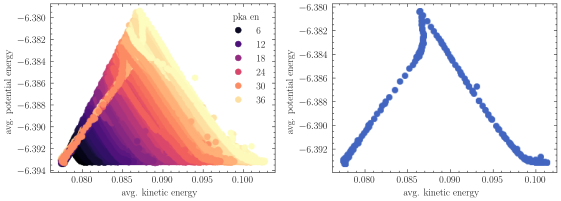

In [8]:
with PlotAndSave("pe_vs_ke", 1, 2) as c:
    fig, axs = c
    sns.scatterplot(df, x="ke_avg", y="pe_avg", hue="pka_en", ax=axs[0], palette=plt.cm.magma, edgecolor=None, rasterized=True)
    sns.scatterplot(df.query("`sim` == 1"), x="ke_avg", y="pe_avg", ax=axs[1], edgecolor=None, rasterized=True)
    axs[0].set(xlabel="avg. kinetic energy", ylabel="avg. potential energy")
    axs[1].set(xlabel="avg. kinetic energy", ylabel="avg. potential energy")
    fig.tight_layout()


# Number of cascades

Files named `nodes_occupancy.*.npz` contain three NumPy arrays: number
of atoms, ID's of atomic sites with defects and their occupancy. Here,
we focus only on the last array to calculate the evolution of defects.

First, we parse `nodes_occupancy.*.npz`. Note that we are using
previously obtained data-frame to estimate the relationship between step
and simulation time.

In [9]:
t, n_vac, en = [], [], []

for i, (sim, pka_en) in enumerate(zip(hyper_prm.sim_dir, hyper_prm.pka_en)):

    frame_to_time = interp1d(*df.query(f"`sim` == {i + 1}").loc[:, ["step", "time"]].values.T, kind="linear", fill_value="extrapolate")

    for res in sorted(glob(f"{sim}/data/nodes_occupancy.*.npz")):
        frame = int(res.split(".")[-2])
        occ = np.load(res)["arr_2"]
        n_vac.append(sum(occ == 0))
        t.append(frame_to_time(frame).item(0))
        en.append(pka_en)


Next, we create a new data-frame containing the count of defects (`fp`
stands for Frenkel pairs).

In [10]:
df_fp = pd.DataFrame(np.vstack([t, n_vac, en]).T, columns=["time", "$n_{\mathrm{FP}}$", "$\epsilon_{\mathrm{PKA}}$"])

Finally, we plot the result.

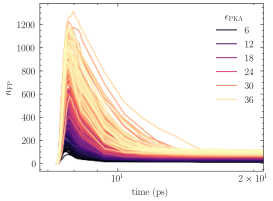

In [11]:
with PlotAndSave("n_fp_ev", 1, 1) as c:
    fig, ax = c

    sns.lineplot(df_fp, x="time", y="$n_{\mathrm{FP}}$", ax=ax, hue="$\epsilon_{\mathrm{PKA}}$", palette=plt.cm.magma, rasterized=True)
    ax.set_xscale("log")
    ax.set_xlim(right=21)
    ax.set_xlabel("time (ps)")
    fig.tight_layout()


# Evolution of the size of collision cascades

Here, we will demonstrate how to derive and visualise a simple measure
of the size of a cascade. At the same time, we will show how to access
files containing coordinates of defects.

To define the dimensions of the cascades, we will use Principal
Component Analysis (PCA) and the covariance of a point cloud
representing the positions of the defects. The volume of the cascade
will be determined by an ellipsoid that encloses approximately 95% of
the Frenkel pairs, which can be estimated both from the eigenvectors of
the covariance and from the inverse transformation associated with the
PCA.

We will begin with a single frame captured from a specific simulation.
This single frame will help us explain the fundamental concepts of our
approach to estimating the volume of a cascade. After that, we will
perform a bulk analysis using all the available data.

## Definition and implementation of volume estimates

First, we define a unit sphere for the purpose of the visualisation.

In [12]:
alpha, beta = np.mgrid[0:2*np.pi:30j, 0:np.pi:30j]
u = np.cos(alpha) * np.sin(beta)
v = np.sin(alpha) * np.sin(beta)
w = np.cos(beta)
UVW = np.vstack([u.flatten(), v.flatten(), w.flatten()]).T

Next, we load the data for a single frame. We will be using both
vacancies and self-interstitials to define the PCA object.

In [13]:
vac = am.load('atom_dump', f"{hyper_prm.root}/pka_001/data/vac_pos.43269")
sia = am.load('atom_dump', f"{hyper_prm.root}/pka_001/data/int_pos.43269")

FPs = np.vstack([vac.atoms.pos, sia.atoms.pos])
pca = PCA(whiten=True)
pca.fit(FPs)

PCA(whiten=True)

Subsequently, we transform doubled unit sphere from transformed to the
original coordinates. This ellipsoid will represent the volume of the
cascade. Note, that our definition of the PCA involves scaling by the
singular values (`whiten=True`). Later, we will show that volume defined
in this way is equivalent to one defined by a covariance matrix.

In [14]:
XYZ = pca.inverse_transform(2 * UVW)
x, y, z = XYZ[:, 0].reshape(u.shape), XYZ[:, 1].reshape(u.shape), XYZ[:, 2].reshape(u.shape)

Now, we can plot the result.

In [15]:

data = [
    go.Scatter3d(x=vac.atoms.pos[:, 0], y=vac.atoms.pos[:, 1], z=vac.atoms.pos[:, 2], mode='markers', name="vac"),
    go.Scatter3d(x=sia.atoms.pos[:, 0], y=sia.atoms.pos[:, 1], z=sia.atoms.pos[:, 2], mode='markers', name="sia"),
    go.Surface(x=x, y=y, z=z, opacity=0.5, showscale = False, name="representatvie volume")
]

fig = go.Figure(data=data)
camera = dict(eye=dict(x=-1, y=2, z=1))
fig.update_layout(
    scene_camera=camera,
    font_family="cmr", font_size=16,
    paper_bgcolor="rgba(0, 0, 0, 0)",
    margin=dict(l=0, r=0, t=0, b=0),
    showlegend=True, legend=dict(x=0.7, y=0.85),
    width=1200, height=1000
)
fig.write_image("./assets/single_cascade.png", scale=1)
# fig.show()

We have seen that the inverse transformation associated with PCA can
give a fair representation of the cascade volume. Now, as part of sanity
checks, we will show that the same information can be obtained using a
covariance matrix. Consider the covariance $\Sigma$ of a cloud of
defects. Since the covariance matrix is positive semidefinite $$
\left| \Sigma \right| = \mathrm{tr} \Lambda,
$$ where relationship $$
\Sigma = R \Lambda R
$$ is the eigenvalue decomposition and defines $\Lambda$. Since the
eigenvalues, assembled in $\Lambda$, and the eigenvectors correspond to
the principal axes, the determinant of the covariance matrix can be used
to calculate the volume of a cascade. Let's demonstrate the parallels
between the results of the PCA transformation and the eigenvalues of the
covariance matrix.

In [16]:
origin = pca.inverse_transform([0, 0, 0])
ellipsoid_pca = np.array([[2, 0, 0], [0, 2, 0], [0, 0, 2]])
ellipsoid = pca.inverse_transform(ellipsoid_pca) - origin

cov = np.cov(FPs.T)
lam, evec = np.linalg.eig(cov)
evec = evec.T

vol_cov = 4 / 3 * np.pi * (2**3) * np.sqrt(np.linalg.det(cov))       # We multiply by 2 all 3 components of the projected standard deviation. 
vol_eig = 4 / 3 * np.pi * (2**3) * np.sqrt(np.prod(lam))             # At the same time covariance correspond to variance, hence the square root.
vol_pca = 4 / 3 * np.pi * np.prod(np.linalg.norm(ellipsoid, axis=1)) # 
print(f"V(COV) ={vol_cov / 10 ** 3: .2f}, V(EIG) ={vol_eig / 10 ** 3: .2f}, V(PCA) ={vol_pca / 10 ** 3: .2f}")

V(COV) = 742.62, V(EIG) = 742.62, V(PCA) = 742.62


Recall that for the normal distribution $\mathcal{N} (\mu, \sigma^2)$,
the interval $(\mu - 2\sigma, \mu + 2\sigma)$ will contain roughly 95%
of samples from this distribution. If we scale accordingly, the
determinant, eigenvalues and transformed ellipsoid, we should arrive at
the volume of the region containing the same fraction of Frenkel pairs.

While the above code demonstrates equivalency of the volume
calculations, the figure below shows the same relationship between
eigenvectors of the covariance matrix and the principal components in
PCA. Both sets of vectors have been scaled to match the representative
ellipsoid.

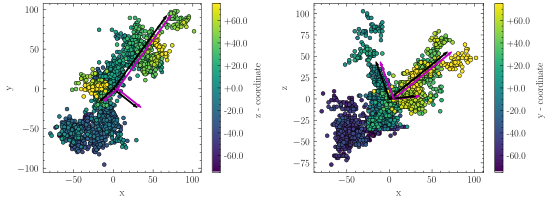

In [17]:
with PlotAndSave("pca_vs_eig", 1, 2) as c:
    fig, axs = c

    axs[0].set_aspect(1)
    axs[1].set_aspect(1)

    _FPs = FPs - FPs.mean(axis=0)
    zo = np.argsort(_FPs[:, 2])     # Order accirding to the "z" coordinate.
    yo = np.argsort(_FPs[:, 1])     # Order accirding to the "y" coordinate.

    s1 = axs[0].scatter(_FPs[zo][:, 0], _FPs[zo][:, 1], c=_FPs[zo][:, 2], s=15, ec="k", lw=0.5, label="FPs", vmin=-75, vmax=75)
    s2 = axs[1].scatter(_FPs[yo][:, 0], _FPs[yo][:, 2], c=_FPs[yo][:, 1], s=15, ec="k", lw=0.5, label="FPs", vmin=-75, vmax=75)

    cbar1 = fig.colorbar(s1, ax=axs[0], label='z - coordinate', format="%+2.1f")
    cbar2 = fig.colorbar(s2, ax=axs[1], label='y - coordinate', format="%+2.1f")

    for pax, lam_i, evec_i in zip(ellipsoid, lam, evec):
        axs[0].arrow(0, 0, pax[0], pax[1], width=1, color="k")
        axs[0].arrow(5, 0, np.sqrt(4 * lam_i) * evec_i[0], np.sqrt(4 * lam_i) * evec_i[1], color="m", width=1)
        axs[1].arrow(0, 0, pax[0], pax[2], width=1, color="k")
        axs[1].arrow(5, 0, np.sqrt(4 * lam_i) * evec_i[0], np.sqrt(4 * lam_i) * evec_i[2], color="m", width=1)

    axs[0].set(xlabel="x", ylabel="y")
    axs[1].set(xlabel="x", ylabel="z")

    fig.tight_layout()


## Evolution of the volume

In this section, we will extend the analysis initially performed on a
single frame to include all available results. As always, we start with
the parsing.

In [18]:
df_vol = pd.DataFrame([])

row = iter(count(0))
for fo, e_pka in zip(hyper_prm.sim_dir, hyper_prm.pka_en):
    for vac_fi in sorted(glob(f"{fo}/data/vac_pos.*")):
        sia_fi = vac_fi.replace("vac", "int")
        vac = am.load('atom_dump', vac_fi)
        sia = am.load('atom_dump', sia_fi)
        cov = np.cov(np.vstack([vac.atoms.pos, sia.atoms.pos]).T)
        det = np.linalg.det(cov)
        if det <= 0.0:
            continue
        i = next(row)
        df_vol.loc[i, "PKA energy"] = e_pka
        v = 4 / 3 * np.pi * (2**3) * np.sqrt(det)
        df_vol.loc[i, "volume"] = v
        df_vol.loc[i, "ESR"] = ((4 * v) / (3 * np.pi))**(1.0 / 3.0)
        sim = int(fo.split("_")[-1])
        frame_to_time = interp1d(*df.query(f"`sim` == {sim}").loc[:, ["step", "time"]].values.T, kind="linear", fill_value="extrapolate")
        frame = int(vac_fi.split(".")[-1])
        df_vol.loc[i, "time"] = frame_to_time(frame)
        df_vol.loc[i, "sim"] = sim


We then follow with the creation of a Pandas data-frame.

In [19]:
df_vol["rel. time"] = 0.0
for sim, _df in df_vol.groupby("sim"):
    _df["rel. time"] = _df["time"] - _df["time"].min()
    df_vol.loc[_df.index, "rel. time"] = _df["rel. time"]

Instead of volume we plot the equivalent sphere radius (ESR), which is
simply the radius of a sphere with the same volume as the given
ellipsoid.

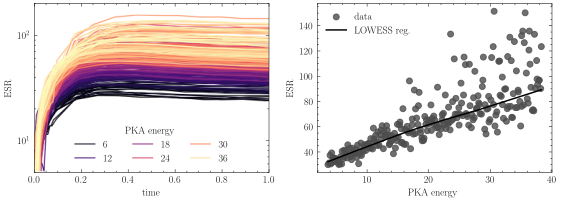

In [20]:
with PlotAndSave("pka_vs_size", 1, 2) as c:
    fig, axs = c

    sns.lineplot(df_vol, x="rel. time", y="ESR", hue="PKA energy", palette=plt.cm.magma, rasterized=True, ax=axs[0])
    axs[0].set(xlim=(0, 1), ylim=(5e+0, 2e+2), xscale="linear", yscale="log", xlabel="time")
    sns.move_legend(axs[0], "lower center", bbox_to_anchor=(.5, 0), ncol=3, title="PKA energy", frameon=False)
    sns.regplot(df_vol.groupby("sim").nth(-10), x="PKA energy", y="ESR", ax=axs[1], ci=99, color="0.3", lowess=True, line_kws=dict(color="k"), label="data")
    axs[1].get_lines()[-1].set_label("LOWESS reg.")
    axs[1].legend()

    fig.tight_layout()


We wish to emphasise that a proper analysis requires unwrapping the
periodic boundary conditions, which is beyond the scope of this
document.

# Damage vs. displacement

To illustrate the difference between displacements and defects (most of
the displaced atoms are occupying equilibrium atomic sites at the end of
the collision cascade), we start with loading the information about the
sites occupancy.

In [21]:
job_id = 0
print(f"PKA energy: {hyper_prm.pka_en[job_id]:.2f} keV")

n_atm, idx, occ = np.load(sorted(glob(f"{hyper_prm.sim_dir[job_id]}/data/nodes_occupancy.*.npz"))[-1]).values()

PKA energy: 36.15 keV


Nest, we load the coordinates of the atomic sites and final positions of
atoms.

In [22]:
fi0 = "{}/dumps/dump.en_min_0".format(hyper_prm.sim_dir[job_id])
fi1 = "{}/dumps/dump.en_1".format(hyper_prm.sim_dir[job_id])

atm0 = am.load('atom_dump', fi0, symbols='Zr')
atm1 = am.load('atom_dump', fi1, symbols='Zr')

Displaced atoms are defined by a threshold distance from their nominal
positions. Since we have periodic boundary conditions, the cyclic
distance must be used.

In [23]:
def delta(x0, x1, l):
    # 1D cyclic difference on a vector component
    dx = np.abs(x0 - x1)
    return np.where(dx > 0.5 * l, dx - l, dx)


def get_cyclic_dist(x0, x1, lx, ly, lz):
    dx = np.vstack(list(starmap(delta, zip(x0.T, x1.T, [lx, ly, lz])))).T
    return np.sqrt((dx**2).sum(axis=-1))

def get_disp_idx(x0, x1, lx, ly, lz, threshold=0.5):
    dist = get_cyclic_dist(x0, x1, lx, ly, lz)
    idx, = np.where(dist > threshold)
    return idx


def_pos = atm0.atoms.pos[idx]

disp = get_disp_idx(atm0.atoms.pos, atm1.atoms.pos, atm0.box.lx, atm0.box.ly, atm0.box.lz, threshold=3)
# disp = np.linalg.norm(atm1.atoms.pos - atm0.atoms.pos, axis=1) > 50.0
print(f"Number of diplaced atoms: {np.sum(disp)}.")

Number of diplaced atoms: 4715519165.


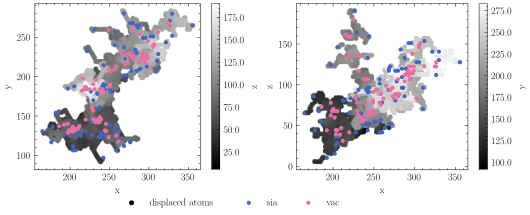

In [24]:
with PlotAndSave("displacement_vs_damage", 1, 2, scale_w=1.1) as c:
    fig, axs = c

    axs[0].set_aspect(1)
    axs[1].set_aspect(1)

    x, y, z = atm1.atoms.pos[disp].T
    zo, yo = np.argsort(z), np.argsort(y)
    s1 = axs[0].scatter(x[zo], y[zo], c=z[zo], s=16, label="displaced atoms", rasterized=True, cmap=plt.cm.gray)
    axs[0].scatter(*def_pos[occ > 1][:, [0, 1]].T, s=10, label="sia")
    axs[0].scatter(*def_pos[occ < 1][:, [0, 1]].T, s=10, label="vac")

    s2 = axs[1].scatter(x[yo], z[yo], c=y[yo], s=16, label="displaced atoms", rasterized=True, cmap=plt.cm.gray)
    axs[1].scatter(*def_pos[occ > 1][:, [0, 2]].T, s=10, label="sia")
    axs[1].scatter(*def_pos[occ < 1][:, [0, 2]].T, s=10, label="vac")

    axs[0].set(xlabel="x", ylabel="y")
    axs[1].set(xlabel="x", ylabel="z")

    axs[0].legend(loc=(0.5, -0.25), ncol=3)

    cbar1 = fig.colorbar(s1, ax=axs[0], label='z', format="%2.1f")
    cbar2 = fig.colorbar(s2, ax=axs[1], label='y', format="%2.1f")



# References

[1] Large-scale Atomic/Molecular Massively Parallel Simulator –
<https://www.lammps.org>

[2] Pressurised water reactor

[3] Wildcard `?` in BASH represents matching of any single character.

[4] Wildcard `?` in BASH represents matching of any single character.

[5] Wildcard `*` in BASH represents matching of any character, any
number of times.